In [ ]:
!unrar x "/content/drive/MyDrive/images1.rar"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/images1.rar

Creating    images1                                                   OK
Creating    images1/images1                                           OK
Extracting  images1/images1/Albrecht_Dürer_1.jpg                           0%  OK 
Extracting  images1/images1/Albrecht_Dürer_10.jpg                          0%  OK 
Extracting  images1/images1/Albrecht_Dürer_100.jpg                         0%  OK 
Extracting  images1/images1/Albrecht_Dürer_101.jpg                         0%  OK 
Extracting  images1/images1/Albrecht_Dürer_102.jpg                         0%  OK 
Extracting  images1/images1/Albrecht_Dürer_103.jpg                         0%  OK 
Extracting  images1/images1/Albrecht_Dürer_104.jpg                         0%  OK 
Extracting  images1/images1/Albrecht_Dürer_105.jpg                         0%

In [ ]:
import os

# Keras functions
import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output

# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

#Torchvision for fast and easy loading and resizing
import torchvision
import torchvision.transforms as transforms

from PIL import Image


In [ ]:
dataset_path = "/content/images1/"
saved_path = '/content/training_data.npy'

WIDTH = 64
HEIGHT = 64
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 250


if not os.path.isfile(saved_path):
    print("\n File not found, loading new data...\n")
    dataset = []
    transform_ds = transforms.Compose([transforms.Resize(IMG_SIZE),]) #define transformation

    image_folder = torchvision.datasets.ImageFolder(root=dataset_path,
                                     transform=transform_ds)

    print('Number of artworks found: ',len(image_folder))


    print("Converting images, this will take a few minutes")
    for i in range (len(image_folder)):
        image_array = numpy.array(image_folder[i][0])
        dataset.append(image_array)
        if (i%500 == 0):
            print("Pictures processed: ", i)

    print("Saving dataset binary file...")
    dataset = np.array(dataset, dtype=np.float32)
    dataset = (dataset - 127.5) / 127.5 #Normalize to [-1 , 1]
    numpy.save(saved_path, dataset)  #Save processed images as npy file

else:
    print("Data found, loading..")
    dataset = np.load(saved_path)

print("Dataset length: ", len(dataset))

Looking for previously saved file...

 File not found, loading new data...

Number of artworks found:  2009
Converting images, this will take a few minutes
Pictures processed:  0
Pictures processed:  500
Pictures processed:  1000
Pictures processed:  1500
Pictures processed:  2000
Saving dataset binary file...
Dataset length:  2009


In [ ]:
dataset.shape

(2009, 64, 64, 3)

In [ ]:
BATCH_SIZE = 32

training_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(9000).batch(BATCH_SIZE)

In [ ]:
training_dataset.batch

<bound method DatasetV2.batch of <_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>>

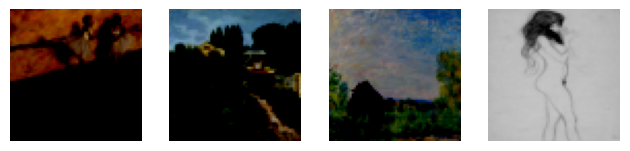

In [ ]:
import matplotlib.pyplot as plt
import random

np.random.shuffle(dataset) #Shuffle the images

fig = plt.figure(figsize=(12,12))
for i in range(1,5):
    fig.add_subplot(6,6,i)
    plt.imshow(dataset[i])
    plt.axis('off')


### Generator Model Architecture:

1. **Input Layer:**
   - Type: Dense
   - Units: 64x64 (resulting in a 64x64-dimensional vector)
   - Activation Function: ReLU

2. **Reshape Layer:**
   - Reshapes the output of the Dense layer into a 4x4x256 tensor.

3. **UpSampling and Convolutional Layers:**
   - Upsampling2D layer followed by Conv2D layer (repeated twice)
   - Each UpSampling2D layer doubles the dimensions, contributing to the generation of higher-resolution images.
   - Conv2D layers with BatchNormalization and ReLU activation are used to capture and enhance features.

4. **Optional Additional Upsampling:**
   - Another UpSampling2D layer and Conv2D layer, contributing to additional upsampling for generating images of higher resolution.

5. **Final Convolutional Layer:**
   - Conv2D layer with tanh activation.
   - Outputs the generated image.

**Rationale:**
- The architecture progressively upsamples the input seed, transforming it into a complex representation of an image.
- BatchNormalization is used to stabilize and accelerate training.
- The final layer uses tanh activation to ensure pixel values are in the range [-1, 1], suitable for image generation.


In [ ]:
def build_generator(seed_size, channels):

    model = Sequential()

    model.add(Dense(64*64,activation="relu",input_dim=seed_size)) #64x64 units
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Optional additional upsampling goes here
    model.add(UpSampling2D(size = (2,2))) #4,4 for 128x128, 2,2 for 64x64
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))


    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

### Discriminator Model Architecture:

1. **Convolutional Layers:**
   - Conv2D layers with increasing filters (32, 64, 128, 256, 512).
   - LeakyReLU activation with a dropout layer after each Conv2D layer.
   - Each layer extracts hierarchical features from the input image.

2. **Flatten and Dense Layer:**
   - Flatten layer collapses the 3D tensor into a 1D vector.
   - Dense layer with a single neuron and a sigmoid activation function.
   - Outputs a probability indicating the authenticity of the input image (real or generated).

**Rationale:**
- The architecture follows a typical convolutional neural network (CNN) structure for image classification.
- LeakyReLU is used to allow a small, non-zero gradient when the input is negative, preventing dead neurons.
- Dropout layers help in regularizing the model.
- The final dense layer with sigmoid activation produces a probability score for binary classification (real or generated).


In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


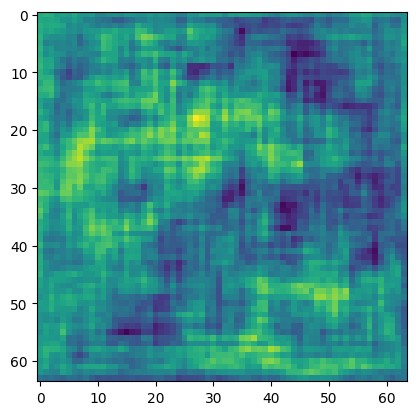

In [ ]:
SEED_SIZE = 100
IMAGE_CHANNELS = 3

generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49998635]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

In [ ]:
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2 # Give the images a little frame

def save_images(cnt, noise):
    #Define the "base" of the saved image as a big black canvas
    image_array = np.full((
      MARGIN + (GENERATED_ROWS * (WIDTH + MARGIN)),
      MARGIN + (GENERATED_COLS * (HEIGHT + MARGIN)), 3),
      0, dtype=np.uint8)

    generated_images =  generator.predict(noise)

    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (WIDTH + 2) + MARGIN
            c = col * (HEIGHT + 2) + MARGIN
            image_array[r:r+WIDTH , c:c+HEIGHT] = generated_images[image_count] * 127.5 + 127.5
            image_count += 1

    output_path  = os.path.join("/content/generated_images/")
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [ ]:
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training = True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(
            gen_loss,
            generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss,
            discriminator.trainable_variables
        )

        generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                generator.trainable_variables))

        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                    discriminator.trainable_variables))

        return gen_loss, disc_loss

In [ ]:
gen_loss = []
disc_loss = []
def train(dataset, epochs):
    # Use a fixed seed for the saved images so we can watch their development
    fixed_seed = np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE))

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        gen_loss.append(g_loss)
        disc_loss.append(d_loss)

        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')

        save_images(epoch, fixed_seed)

In [ ]:
train(training_dataset, EPOCHS)

Epoch 1, gen loss = 1.1706089973449707, disc loss = 1.5555025339126587
2/2 [==============================] - 0s 39ms/step
Epoch 2, gen loss = 1.0662609338760376, disc loss = 1.4777451753616333
2/2 [==============================] - 0s 24ms/step
Epoch 3, gen loss = 0.9295511841773987, disc loss = 1.5674190521240234
2/2 [==============================] - 0s 24ms/step
Epoch 4, gen loss = 0.9965185523033142, disc loss = 1.4279799461364746
2/2 [==============================] - 0s 24ms/step
Epoch 5, gen loss = 1.049003005027771, disc loss = 1.4103413820266724
2/2 [==============================] - 0s 24ms/step
Epoch 6, gen loss = 1.180712103843689, disc loss = 1.367121934890747
2/2 [==============================] - 0s 24ms/step
Epoch 7, gen loss = 1.1401563882827759, disc loss = 1.3219212293624878
2/2 [==============================] - 0s 39ms/step
Epoch 8, gen loss = 1.2994664907455444, disc loss = 1.2236112356185913
2/2 [==============================] - 0s 24ms/step
Epoch 9, gen loss =

### Training Process Documentation:

#### Choice of Loss Function:
- The loss functions used are Binary Crossentropy for both the generator and discriminator. Binary Crossentropy is well-suited for binary classification tasks, which is the case for the GAN discriminator, where it aims to distinguish between real and generated images. The generator, on the other hand, seeks to generate images that deceive the discriminator, hence the same loss function is applicable.

#### Choice of Optimizers and Learning Rates:
- The chosen optimizers are Adam optimizers for both the generator and discriminator.
- Learning rates:
  - Generator optimizer learning rate: 1.2e-4
  - Discriminator optimizer learning rate: 1.5e-4
- The learning rates were chosen based on common practices in GAN training. Lower learning rates are typically used to prevent model divergence, and adjusting these rates can have a significant impact on training stability.

#### Training Loop:
- The training loop runs for the specified number of epochs, iterating over the training dataset in each epoch.
- In each training step, the generator and discriminator are trained simultaneously with a batch of real images from the dataset. The generator generates fake images from random seeds, and the discriminator evaluates both real and fake images.
- The generator aims to minimize its loss, making the generated images more convincing, while the discriminator aims to correctly classify real and fake images, thus minimizing its own loss.
- The gradients of the generator and discriminator losses are calculated using GradientTape, and Adam optimizers are used to apply the gradients and update the respective model parameters.

#### Monitoring and Saving Progress:
- The progress of the training process is monitored by printing the generator and discriminator losses after each epoch.
- Generated images are saved at regular intervals during training to visualize the progression of the generator's output.

#### Reasoning Behind Choices:
- Binary Crossentropy is a common choice for GANs due to its suitability for binary classification tasks.
- Adam optimizers are preferred for their adaptive learning rate properties, helping in training stability.
- The chosen learning rates are in a commonly used range for GANs, and adjusting them may be necessary based on observed training behavior.
- Saving generated images at intervals helps to visually inspect the quality and progression of generated samples throughout training.



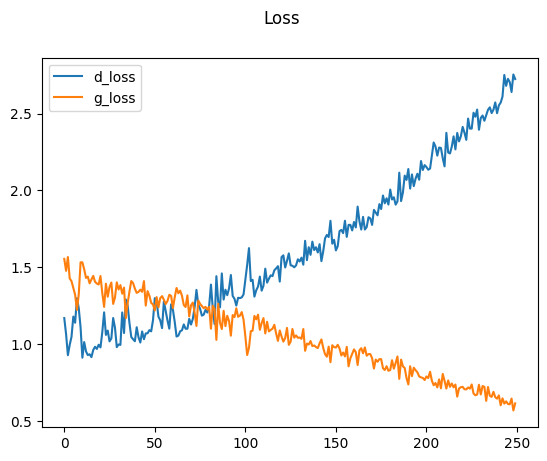

In [ ]:
plt.suptitle('Loss')
plt.plot(gen_loss, label='d_loss')
plt.plot(disc_loss, label='g_loss')
plt.legend()
plt.show()

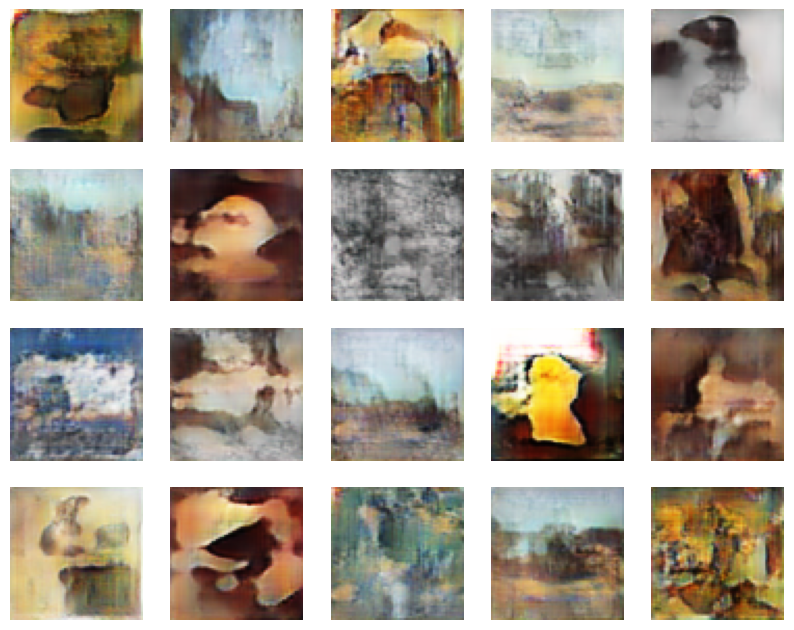

In [ ]:
seed2 = tf.random.normal([20, SEED_SIZE])
generated_images2 = generator(seed2, training = True)

generated_images2 = 0.5 * generated_images2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(0,20):
    fig.add_subplot(5,5,i+1)
    plt.imshow(generated_images2[i])
    plt.axis('off')

In [ ]:
generator.save_weights('generator_weights.h5')

In [ ]:
from scipy.stats import entropy


def calculate_is(generated_images):
    # Convert pixel values to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    # Calculate class probabilities (assuming binary classification)
    p_yx = generated_images.mean(axis=(1, 2, 3))

    # Calculate marginal class probabilities
    p_y = np.expand_dims(p_yx.mean(axis=0), 0)

    # Calculate KL divergence and exponential of it
    kl_d = entropy(p_yx.T, qk=p_y.T)
    is_score = np.exp(np.mean(kl_d))

    return is_score

# Calculate IS without InceptionV3 model
seed2 = tf.random.normal([32, SEED_SIZE])
generated_images2 = generator(seed2, training = True)
is_score = calculate_is(np.array(generated_images2))
print(f'IS: {is_score}')


IS: 1.0568735599517822


In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = np.cov(generated_features, rowvar=False)

    # Ensure that covariance matrices are 2D
    sigma_real = np.atleast_2d(sigma_real)
    sigma_gen = np.atleast_2d(sigma_gen)

    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real @ sigma_gen)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid

In [ ]:
def generate_fake_images(generator, num_images):
    seed2 = tf.random.normal([num_images, SEED_SIZE])
    fake_images = generator(seed2, training = True)
    return fake_images



num_images = 32  # Adjust the number of generated images
real_images = next(iter(training_dataset.batch(num_images)))
real_features = np.array(real_images)[0]

# Generate fake images
fake_images = generate_fake_images(generator, num_images)
fake_images = 0.5 * fake_images + 0.5
fake_images=np.array(fake_images)


In [ ]:
real_features = real_features.reshape(-1,1)
fake_images= fake_images.reshape(-1,1)

In [ ]:
fake_images.shape

(393216, 1)

In [ ]:
fid = calculate_fid(real_features, fake_images)
print(f'FID: {fid}')

FID: 0.36749804820513565


### Steps to Deploy Trained GAN:

1. **Save Trained Model:**
   - Save the trained generator model and any other necessary artifacts (e.g., weights) to a file. This can be done using TensorFlow's `model.save()` or a similar method.

2. **Create a Flask Application:**
   - Set up a Flask application that will serve as the backend for the API. This application will handle incoming requests, generate images using the trained GAN, and return the results.

3. **Install Necessary Dependencies:**
   - Ensure that all necessary dependencies are specified in a `requirements.txt` file. This includes libraries such as TensorFlow, Flask, and any other dependencies your application requires.

4. **Containerize the Application If you want:**
   - Containerize the Flask application using a tool like Docker. Create a `Dockerfile` to define the environment and dependencies needed for your application.

5. **Choose a Cloud Service Provider:**
   - Decide on a cloud service provider (e.g., AWS, Google Cloud, Azure) based on your preferences, requirements, and familiarity. Each provider has its own set of services for deploying and managing applications.

6. **Set Up Cloud Environment:**
   - Create an account on the chosen cloud platform if you don't have one. Set up a project or workspace and configure necessary resources, such as storage (for model files) and compute (for running the Flask application).

7. **Deploy Flask Application:**
   - Deploy the Flask application to a cloud service. Depending on the provider, this could involve using services like AWS Elastic Beanstalk, Google App Engine, or Azure App Service. Deploy the Docker container if applicable.

8. **Expose API Endpoint:**
   - Expose an API endpoint that clients can use to request image generation. This endpoint should accept relevant parameters (e.g., seed for image generation) and return the generated image.

9. **Ensure Scalability:**
   - Configure the deployed application to handle real-time requests efficiently. This may involve configuring auto-scaling settings to handle varying loads.

10. **Implement Security Measures:**
   - Implement security measures, such as authentication and authorization, to protect the API endpoint. This is crucial, especially if the service is exposed to the public.

11. **Monitoring and Logging:**
   - Set up monitoring and logging to track the performance and health of the deployed application. Cloud providers often offer tools for monitoring resource usage, logs, and errors.

12. **Test the API:**
   - Test the deployed API to ensure that it works as expected. Check the response times, scalability, and overall performance.

13. **API Documentation:**
   - Provide clear and comprehensive documentation for the API, including details on how to make requests and interpret responses.

14. **Cost Management:**
   - Monitor and manage costs associated with the deployed application. Optimize resource usage and consider cost-effective options provided by the cloud platform.
